# 📊 Análise de Vendas de Supermercados

Este notebook documenta todo o processo de **limpeza, tratamento e análise exploratória** dos dados de vendas de supermercados.

O objetivo é identificar padrões, tendências e insights relevantes para o desempenho de vendas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from pydantic import BaseModel, Field, field_validator

## 🔧 Configuração do DataLoader

In [2]:

class DataLoaderConfig(BaseModel):
    url: str = Field(..., description="URL do arquivo JSON")
    chave: str | None = Field(None, description="Chave do JSON a ser carregada")

    @field_validator("url")
    @classmethod
    def validar_url(cls, v: str) -> str:
        if not (v.startswith("http://") or v.startswith("https://")):
            raise ValueError("URL deve começar com http:// ou https://")
        return v


## 🧹 Funções de Limpeza e Tratamento de Dados

In [11]:
def load_data(config: DataLoaderConfig) -> pd.DataFrame:
    response = requests.get(config.url)
    response.raise_for_status()
    data = response.json()

    if isinstance(data, dict) and config.chave:
        data = data[config.chave]

    if isinstance(data, list):
        df = pd.json_normalize(data)
    elif isinstance(data, dict):
        df = pd.json_normalize([data])
    else:
        df = pd.DataFrame([data])

    return df


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Remover coluna descartável
    if "item.item_quantidade_venda" in df.columns:
        df.drop(columns=["item.item_quantidade_venda"], inplace=True)

    # Padronizar coluna de gordura
    mapping = {
        "BTG": "Baixo Teor de Gordura",
        "baixo teor de gordura": "Baixo Teor de Gordura",
        "reg": "Regular"
    }
    if "item.item_conteudo_gordura" in df.columns:
        df["item.item_conteudo_gordura"] = df["item.item_conteudo_gordura"].replace(mapping)

    return df


def handle_nulls(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.drop_duplicates(inplace=True)

    # Tratar item_peso: preencher com mediana
    if "item.item_peso" in df.columns:
        df["item.item_peso"] = df["item.item_peso"].fillna(df["item.item_peso"].median())

    # Tratar loja_tamanho: preencher com "Não registrado"
    if "loja.loja_tamanho" in df.columns:
        df["loja.loja_tamanho"] = df["loja.loja_tamanho"].fillna("Não registrado")

    df.reset_index(drop=True, inplace=True)
    return df


def process_pipeline(config: DataLoaderConfig) -> pd.DataFrame:
    df = load_data(config)
    df = clean_data(df)
    df = handle_nulls(df)
    return df

## 📥 Carregamento dos Dados

In [12]:

configs = {
    "vendas": DataLoaderConfig(
        url='https://raw.githubusercontent.com/YuriArduino/Estudos_Artificial_Intelligence/refs/heads/Dados/dados_vendas.json',
        chave="dados_vendas"
    )
}

df_final = process_pipeline(configs["vendas"])
print(f"Shape final do DataFrame: {df_final.shape}")
df_final.head()


Shape final do DataFrame: (8523, 12)


,item_identificador,loja_identificador,vendas_totais,item.item_peso,item.item_conteudo_gordura,item.item_visibilidade,item.item_tipo,item.item_preco,loja.loja_ano_estabelecimento,loja.loja_tamanho,loja.loja_tipo_localizacao,loja.loja_tipo
0,FDB08,OUT018,176503.58,6.055,Baixo Teor de Gordura,0.031230,Frutas e Vegetais,160.36,2019,Médio,Nível 3,Supermercado Tipo 2
1,DRQ35,OUT049,185758.20,9.300,Baixo Teor de Gordura,0.042357,Bebidas Alcoólicas,123.24,2009,Médio,Nível 1,Supermercado Tipo 1
2,FDD14,OUT018,165983.94,20.700,Baixo Teor de Gordura,0.170500,Enlatados,184.13,2019,Médio,Nível 3,Supermercado Tipo 2
3,FDY37,OUT045,314923.40,17.000,Regular,0.026623,Enlatados,144.25,2012,Não registrado,Nível 2,Supermercado Tipo 1
4,FDY59,OUT018,64782.34,8.195,Baixo Teor de Gordura,0.000000,Confeitaria,93.15,2019,Médio,Nível 3,Supermercado Tipo 2


## 🔍 Análise Exploratória dos Dados

In [5]:
df_final.describe(include='all')

,item_identificador,loja_identificador,vendas_totais,item.item_peso,item.item_conteudo_gordura,item.item_visibilidade,item.item_tipo,item.item_preco,loja.loja_ano_estabelecimento,loja.loja_tamanho,loja.loja_tipo_localizacao,loja.loja_tipo
count,8523,8523,8.523000e+03,8523.00000,8523,8523.000000,8523,8523.000000,8523.000000,8523,8523,8523
unique,1559,10,NaN,NaN,2,NaN,16,NaN,NaN,4,3,4
top,FDG33,OUT027,NaN,NaN,Baixo Teor de Gordura,NaN,Frutas e Vegetais,NaN,NaN,Médio,Nível 3,Supermercado Tipo 1
freq,10,935,NaN,NaN,5517,NaN,1232,NaN,NaN,2793,3350,5577
mean,NaN,NaN,2.181289e+05,12.81342,NaN,0.066132,NaN,140.992810,2007.831867,NaN,NaN,NaN
std,NaN,NaN,1.706500e+05,4.22724,NaN,0.051598,NaN,62.275166,8.371760,NaN,NaN,NaN
min,NaN,NaN,3.329000e+03,4.55500,NaN,0.000000,NaN,31.290000,1995.000000,NaN,NaN,NaN
25%,NaN,NaN,8.342474e+04,9.31000,NaN,0.026989,NaN,93.825000,1997.000000,NaN,NaN,NaN
50%,NaN,NaN,1.794331e+05,12.60000,NaN,0.053931,NaN,143.010000,2009.000000,NaN,NaN,NaN
75%,NaN,NaN,3.101296e+05,16.00000,NaN,0.094585,NaN,185.645000,2014.000000,NaN,NaN,NaN


## 📊 Vendas por Tamanho da Loja

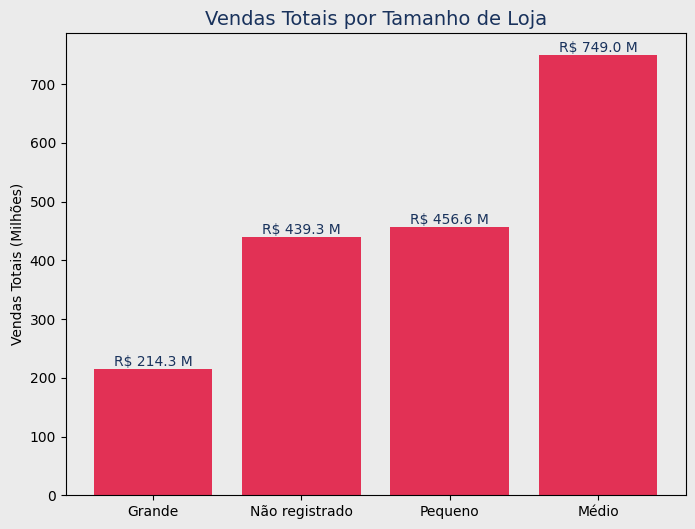

In [6]:

vendas_por_tamanho = df_final.groupby("loja.loja_tamanho")["vendas_totais"].sum().sort_values()

plt.figure(figsize=(8,6))
bars = plt.bar(vendas_por_tamanho.index, vendas_por_tamanho.values/1e6, color="#e23155")
plt.gca().set_facecolor("#ebebeb")
plt.gcf().set_facecolor("#ebebeb")
plt.title("Vendas Totais por Tamanho de Loja", fontsize=14, color="#19325c")

for bar, valor in zip(bars, vendas_por_tamanho.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"R$ {valor/1e6:.1f} M", ha="center", va="bottom", color="#19325c")

plt.ylabel("Vendas Totais (Milhões)")
plt.show()


## 🏪 Vendas por Tipo de Loja

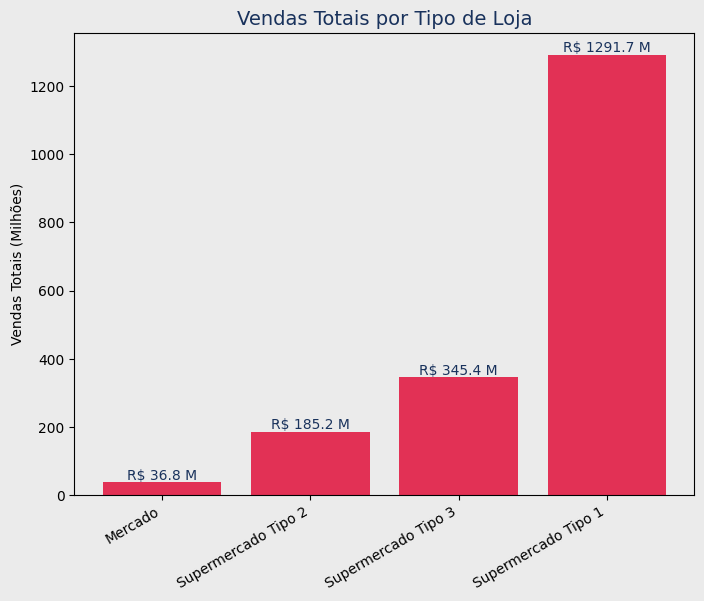

In [13]:
vendas_por_tipo = df_final.groupby("loja.loja_tipo")["vendas_totais"].sum().sort_values()

plt.figure(figsize=(8,6))
bars = plt.bar(vendas_por_tipo.index, vendas_por_tipo.values/1e6, color="#e23155")
plt.gca().set_facecolor("#ebebeb")
plt.gcf().set_facecolor("#ebebeb")
plt.title("Vendas Totais por Tipo de Loja", fontsize=14, color="#19325c")

for bar, valor in zip(bars, vendas_por_tipo.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"R$ {valor/1e6:.1f} M", ha="center", va="bottom", color="#19325c")

plt.ylabel("Vendas Totais (Milhões)")
plt.xticks(rotation=30, ha="right")
plt.show()


## 🍎 Vendas por Categoria de Produto

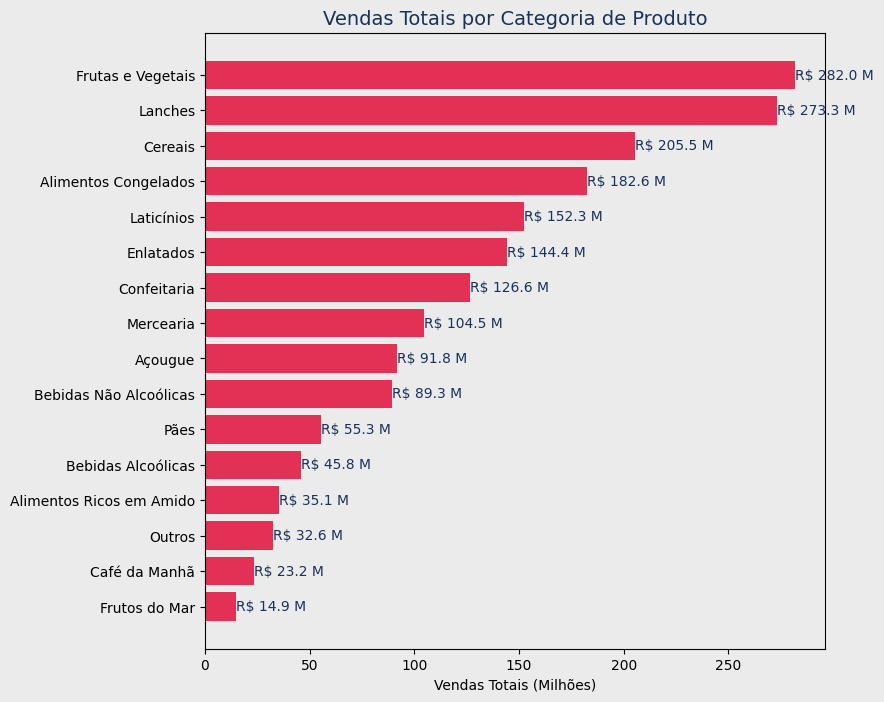

In [8]:

vendas_por_item = df_final.groupby("item.item_tipo")["vendas_totais"].sum().sort_values()

plt.figure(figsize=(8,8))
bars = plt.barh(vendas_por_item.index, vendas_por_item.values/1e6, color="#e23155")
plt.gca().set_facecolor("#ebebeb")
plt.gcf().set_facecolor("#ebebeb")
plt.title("Vendas Totais por Categoria de Produto", fontsize=14, color="#19325c")

for bar, valor in zip(bars, vendas_por_item.values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"R$ {valor/1e6:.1f} M", va="center", ha="left", color="#19325c")

plt.xlabel("Vendas Totais (Milhões)")
plt.show()


## 🥓 Vendas por Conteúdo de Gordura

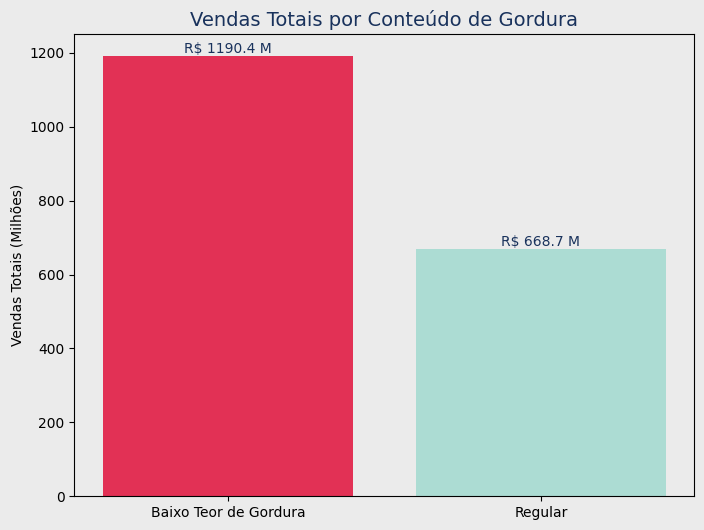

In [9]:

vendas_por_gordura = df_final.groupby("item.item_conteudo_gordura")["vendas_totais"].sum()

cores = {
    "Baixo Teor de Gordura": "#e23155",
    "Regular": "#acdcd3"
}

plt.figure(figsize=(8,6))
bars = plt.bar(vendas_por_gordura.index, vendas_por_gordura.values/1e6,
               color=[cores[c] for c in vendas_por_gordura.index])
plt.gca().set_facecolor("#ebebeb")
plt.gcf().set_facecolor("#ebebeb")
plt.title("Vendas Totais por Conteúdo de Gordura", fontsize=14, color="#19325c")

for bar, valor in zip(bars, vendas_por_gordura.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"R$ {valor/1e6:.1f} M", ha="center", va="bottom", color="#19325c")

plt.ylabel("Vendas Totais (Milhões)")
plt.show()


## 📅 Vendas por Ano de Estabelecimento da Loja

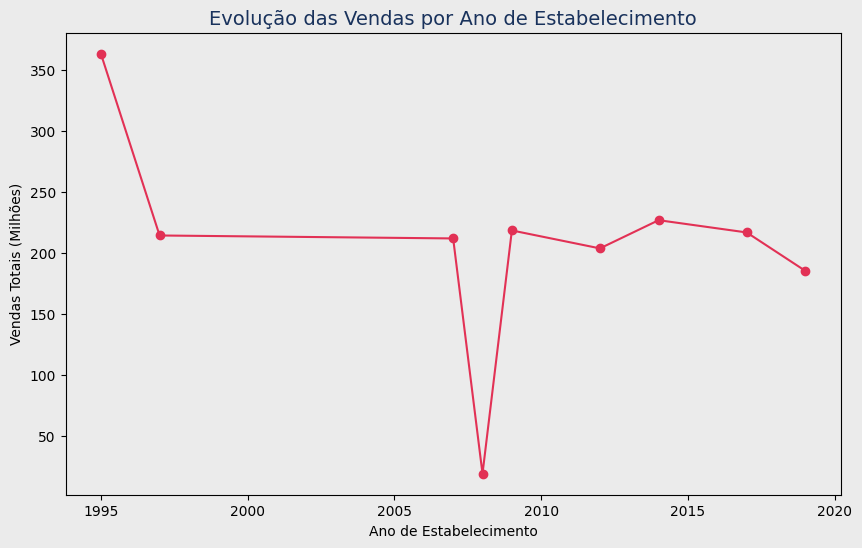

In [10]:

vendas_por_ano = df_final.groupby("loja.loja_ano_estabelecimento")["vendas_totais"].sum()

plt.figure(figsize=(10,6))
plt.plot(vendas_por_ano.index, vendas_por_ano.values/1e6, marker="o", color="#e23155")
plt.gca().set_facecolor("#ebebeb")
plt.gcf().set_facecolor("#ebebeb")
plt.title("Evolução das Vendas por Ano de Estabelecimento", fontsize=14, color="#19325c")
plt.ylabel("Vendas Totais (Milhões)")
plt.xlabel("Ano de Estabelecimento")
plt.show()


## Tratamento e Análise do Ano de Estabelecimento da Loja

Os códigos a seguir realizam o tratamento e a análise do ano de estabelecimento das lojas:

O primeiro bloco de código realiza os seguintes passos:

1.  **Agrupa os dados** pelo ano de estabelecimento da loja e calcula a soma total das vendas para cada ano.
2.  **Conta a quantidade de lojas** únicas para cada ano de estabelecimento.
3.  **Cria um novo DataFrame** chamado `df_ano` combinando as vendas totais e a contagem de lojas por ano.
4.  **Calcula a média de vendas por loja** para cada ano, dividindo as vendas totais pelo número de lojas.
5.  **Imprime o DataFrame `df_ano`** para mostrar os resultados.
6.  **Cria um gráfico** com dois eixos Y: um para as vendas totais (em barras) e outro para o número de lojas (em linha), ambos plotados contra o ano de estabelecimento. Isso ajuda a visualizar a relação entre as vendas e a quantidade de lojas abertas em cada ano.

                               vendas_totais  n_lojas  media_vendas_por_loja
loja.loja_ano_estabelecimento                                               
1995                            3.633620e+08        2           1.816810e+08
1997                            2.142664e+08        1           2.142664e+08
2007                            2.118395e+08        1           2.118395e+08
2008                            1.883402e+07        1           1.883402e+07
2009                            2.183970e+08        1           2.183970e+08
2012                            2.036725e+08        1           2.036725e+08
2014                            2.268123e+08        1           2.268123e+08
2017                            2.167465e+08        1           2.167465e+08
2019                            1.851823e+08        1           1.851823e+08


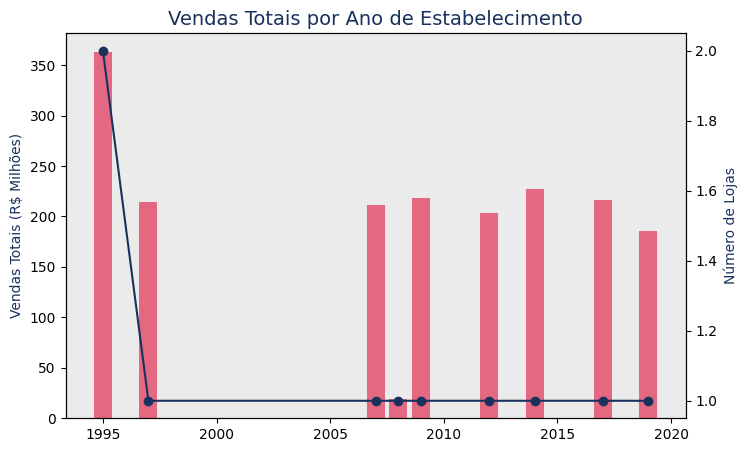

In [14]:
# 1. Total por ano
vendas_por_ano = df_final.groupby("loja.loja_ano_estabelecimento")["vendas_totais"].sum()

# 2. Quantidade de lojas por ano (corrigindo para loja_identificador)
lojas_por_ano = df_final.groupby("loja.loja_ano_estabelecimento")["loja_identificador"].nunique()

# 3. Juntar em um DataFrame para análise comparativa
df_ano = pd.DataFrame({
    "vendas_totais": vendas_por_ano,
    "n_lojas": lojas_por_ano
})
df_ano["media_vendas_por_loja"] = df_ano["vendas_totais"] / df_ano["n_lojas"]

print(df_ano)

# 4. Visualização
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,5))

# Barras = vendas totais
ax1.bar(df_ano.index, df_ano["vendas_totais"]/1e6, color="#e23155", alpha=0.7)
ax1.set_ylabel("Vendas Totais (R$ Milhões)", color="#19325c")
ax1.set_facecolor("#ebebeb")
ax1.set_title("Vendas Totais por Ano de Estabelecimento", fontsize=14, color="#19325c")

# Linha = número de lojas
ax2 = ax1.twinx()
ax2.plot(df_ano.index, df_ano["n_lojas"], color="#19325c", marker="o")
ax2.set_ylabel("Número de Lojas", color="#19325c")

plt.show()

O segundo bloco de código faz o seguinte:

1.  **Cria uma cópia** do DataFrame `df_ano` original e a nomeia como `df_ano_corrigido`.
2.  **Substitui o valor das vendas totais para o ano de 2008** pela média das vendas totais dos anos de 2007 e 2009. Isso é feito para corrigir a anomalia observada no gráfico anterior, onde o ano de 2008 apresentava vendas muito baixas devido a uma única loja com baixo desempenho.
3.  **Recalcula a média de vendas por loja para o ano de 2008** utilizando a nova venda total corrigida e o número de lojas (que permanece 1 para aquele ano).
4.  **Imprime o DataFrame `df_ano_corrigido`** para mostrar os valores após a correção.

In [15]:
df_ano_corrigido = df_ano.copy()

# Substituir 2008 pela média de 2007 e 2009
df_ano_corrigido.loc[2008, "vendas_totais"] = (
    df_ano.loc[2007, "vendas_totais"] + df_ano.loc[2009, "vendas_totais"]
) / 2

df_ano_corrigido.loc[2008, "media_vendas_por_loja"] = (
    df_ano.loc[2007, "media_vendas_por_loja"] + df_ano.loc[2009, "media_vendas_por_loja"]
) / 2

print(df_ano_corrigido)

                               vendas_totais  n_lojas  media_vendas_por_loja
loja.loja_ano_estabelecimento                                               
1995                            3.633620e+08        2           1.816810e+08
1997                            2.142664e+08        1           2.142664e+08
2007                            2.118395e+08        1           2.118395e+08
2008                            2.151182e+08        1           2.151182e+08
2009                            2.183970e+08        1           2.183970e+08
2012                            2.036725e+08        1           2.036725e+08
2014                            2.268123e+08        1           2.268123e+08
2017                            2.167465e+08        1           2.167465e+08
2019                            1.851823e+08        1           1.851823e+08


O terceiro bloco de código é responsável pela visualização comparativa:

1.  **Recria o DataFrame `df_ano` original** e o `df_ano_corrigido` dentro desta célula para garantir que as visualizações usem os dados corretos, incluindo a correção feita no passo anterior.
2.  **Cria uma figura com dois subplots**, um ao lado do outro, para comparar os gráficos.
3.  **No primeiro subplot**, plota a média de vendas por loja do DataFrame **original** (`df_ano`) ao longo dos anos, mostrando a queda em 2008.
4.  **No segundo subplot**, plota a média de vendas por loja do DataFrame **corrigido** (`df_ano_corrigido`) ao longo dos anos, mostrando a série temporal das vendas por loja sem a anomalia de 2008.
5.  **Define os títulos e rótulos** para cada gráfico para facilitar a compreensão.
6.  **Exibe os dois gráficos** lado a lado para comparação.

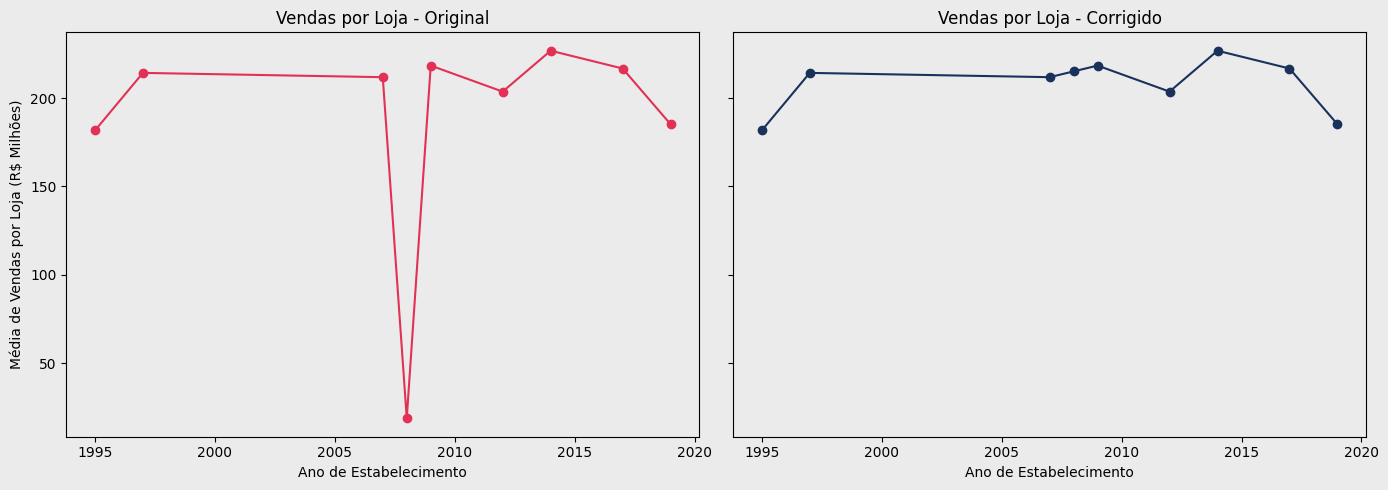

In [16]:
import matplotlib.pyplot as plt

# --- Dataset original agrupado ---
df_ano = (
    df_final.groupby("loja.loja_ano_estabelecimento")
    .agg(
        vendas_totais=("vendas_totais", "sum"),
        n_lojas=("loja_identificador", "nunique")
    )
)
df_ano["media_vendas_por_loja"] = df_ano["vendas_totais"] / df_ano["n_lojas"]

# --- Corrigir 2008 com interpolação ---
df_ano_corrigido = df_ano.copy()
df_ano_corrigido.loc[2008, "vendas_totais"] = (
    df_ano.loc[2007, "vendas_totais"] + df_ano.loc[2009, "vendas_totais"]
) / 2
df_ano_corrigido.loc[2008, "media_vendas_por_loja"] = (
    df_ano.loc[2007, "media_vendas_por_loja"] + df_ano.loc[2009, "media_vendas_por_loja"]
) / 2

# --- Plotagem ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Gráfico original
axes[0].plot(df_ano.index, df_ano["media_vendas_por_loja"]/1e6, marker="o", color="#e23155")
axes[0].set_title("Vendas por Loja - Original")
axes[0].set_xlabel("Ano de Estabelecimento")
axes[0].set_ylabel("Média de Vendas por Loja (R$ Milhões)")
axes[0].set_facecolor("#ebebeb")
fig.patch.set_facecolor("#ebebeb")

# Gráfico corrigido
axes[1].plot(df_ano_corrigido.index, df_ano_corrigido["media_vendas_por_loja"]/1e6, marker="o", color="#19325c")
axes[1].set_title("Vendas por Loja - Corrigido")
axes[1].set_xlabel("Ano de Estabelecimento")
axes[1].set_facecolor("#ebebeb")

plt.tight_layout()
plt.show()

Esses códigos juntos permitem analisar as vendas por ano de estabelecimento, identificar a anomalia em 2008 causada por uma única loja e visualizar o impacto dessa correção na série temporal da média de vendas por loja.

## ✅ Conclusões

- As vendas estão distribuídas de forma desigual entre tamanhos e tipos de loja.
- Algumas categorias de produto concentram mais vendas.
- Existe uma queda expressiva em 2008 devido à abertura de apenas **uma loja com baixo desempenho**.

Este notebook fornece uma base sólida para futuras análises e construção de modelos preditivos.